In [1]:
import torch
import numpy as np
from collections import defaultdict

class TBHNN(torch.nn.Module):
    """
    Tight-binding Hamiltonian neural network
    """

    def __init__(self):
        super(TBHNN, self).__init__()
        self.H_size_added = 0
        self.std=0.1
        
    def read_training_set(self, references, k_vectors):
        num_k, num_b = references.shape
        self.num_b = num_b
        self.num_k = num_k
        self.H_size_init = num_b
        self.H_size = num_b
        self.references = torch.tensor(references, dtype=torch.float32, requires_grad=True)
        self.k_vectors = torch.tensor(k_vectors, dtype=torch.float32, requires_grad=True)
        

    
    def define_TB_representation(self, vectors_without_opposite):
        
        num_r = len(vectors_without_opposite)
        self.num_r = num_r
        self.R = torch.nn.Parameter(torch.zeros((num_r, 3), dtype=torch.float32))

        
        new_R_values = []
        for i, vector in enumerate(vectors_without_opposite):
            if not np.all(np.isclose(vector, 0.0)):
                new_R_values.append(torch.tensor(vector, dtype=torch.float32))
            else:
                new_R_values.append(torch.zeros(3, dtype=torch.float32))

        new_R = torch.stack(new_R_values)

        self.R = torch.nn.Parameter(new_R)

        self.R_without_opposite = vectors_without_opposite

              
        
    def reset_optimizer(self,optimizer):
        optimizer.state = defaultdict(dict)

    def einitialize(self):
        self.H_R = torch.nn.ParameterList()  
        self.H_size = self.H_size_init + self.H_size_added
        for i in self.R_without_opposite:
            H_tmp = torch.nn.Parameter(torch.randn((self.H_size, self.H_size), dtype=torch.complex64) * self.std)
            if np.sum(np.abs(i)) != 0:
                self.H_R.append(H_tmp)
                self.H_R.append(H_tmp.t())  # Transpose the matrix in PyTorch
            else:
                self.H_R.append(H_tmp + H_tmp.t())  # Ensure that H(R=[0,0,0]) is symmetric


    # Placeholder for compute_bands method, will be filled in later
    def compute_bands(self):
        reproduced_bands = torch.zeros((self.num_k, self.H_size), dtype=torch.float32)
        
        for i in range(self.num_k):
            K = torch.zeros((self.H_size, self.H_size), dtype=torch.complex64)
            for j in range(self.num_r):
                exp_factor = torch.exp(-1j * np.pi * torch.matmul(self.k_vectors[i], self.R[j]))
                K += exp_factor * self.H_R[j]
                
            # Eigenvalues are computed from the Hermitian part of K to ensure they are real
            eigenvalues, _ = torch.linalg.eigh(K + K.conj().T)
            reproduced_bands[i] = eigenvalues.real

        # Sort the bands and discard those not needed for loss computation
        reproduced_bands = reproduced_bands[:, int(self.H_size_added/2):int(self.H_size_added//2)+self.num_b]
        self.bandstructure = reproduced_bands

        return reproduced_bands

In [2]:

rvectors_without_opposite = np.array([[0,0,0],[0,0,1],], dtype=np.int32) # in units of[a, b, c] (a, b, and c are the real-space basis vectors; [l, n, m] means the lattice vector l*a+n*b+m*c)
# Load training data
references = np.load("./data/input/InSe Nanoribbon/InSe-references.npy")
k_vectors = np.load("./data/input/InSe Nanoribbon/InSe-kpoints.npy") # in units of 1/2pi*[ak, bk, ck] (ak, bk, and ck are the corresponding k-space basis vectors; [l, n, m] means the k-vector (l/2pi)*ak+(n/2pi)*bk+(m/2pi)*ck)


# Initialize the model
tbhnn = TBHNN()


def fitting(optimizer, threshold, choosen_loss,max_training_steps,loss_file,loss_file_path,loss_file_reset,loss_file_path_reset):
    step=0
    global step_tot
    while step<max_training_steps :
        optimizer.zero_grad()
        
        # Compute the loss and perform backward pass
        reproduced_bands = tbhnn.compute_bands()
        loss=choosen_loss((reproduced_bands-tbhnn.references)**2)
        
        loss.backward()
        optimizer.step()
        loss_value=loss.item()
        # Print loss every 10 steps
        if step % 10 == 0:
            #print(f"Step {step}: Loss = {loss.item()}")
            with open(loss_file_path, 'a') as loss_file:
                loss_file.write(f"{step_tot},{loss_value}\n")
        step+=1
        step_tot+=1
        if loss_value<threshold :
            break
    if step>=max_training_steps :            
        print(f"Reseated model parameters at step {step}")
        return False
    else:
        print("Convergence reached.")
        return True

def main(choosen_optimizer,lr,loss_file_path,loss_file_path_reset,loss,basis_added_step,max_training_steps,threshold,fitting) :
    with open(loss_file_path, 'w') as loss_file:
        loss_file.write("step,loss\n")
    with open(loss_file_path_reset, 'w') as loss_file_reset:
        loss_file.write("number_reset,\n")
    optimizer = choosen_optimizer(tbhnn.parameters(), lr)
    finished = fitting(optimizer, threshold,loss, max_training_steps,loss_file,loss_file_path,loss_file_reset,loss_file_path_reset)
    
    while finished == False:
        tbhnn.H_size_added += basis_added_step
        tbhnn.einitialize()
        # tbhnn.reset_optimizer(optimizer)
        optimizer = choosen_optimizer(tbhnn.parameters(), lr)
        finished = fitting(optimizer, threshold,loss, max_training_steps,loss_file,loss_file_path)

    
    return 

def stocatstic_reset_fitting(optimizer, threshold, choosen_loss,max_training_steps,loss_file,loss_file_path,loss_file_reset,loss_file_path_reset):
    step=0
    number_reset=0
    global step_tot
    step_reset = int(np.random.exponential(max_training_steps))
    while step<step_reset :
        optimizer.zero_grad()
        
        # Compute the loss and perform backward pass
        reproduced_bands = tbhnn.compute_bands()
        loss=choosen_loss((reproduced_bands-tbhnn.references)**2)
        
        loss.backward()
        optimizer.step()
        loss_value=loss.item()
        # Print loss every 10 steps
        if step % 10 == 0:
            #print(f"Step {step}: Loss = {loss.item()}")
            with open(loss_file_path, 'a') as loss_file:
                loss_file.write(f"{step_tot},{loss_value}\n")
        step+=1
        step_tot+=1
        if loss_value<threshold :
            break
    if step>=step_reset :
        number_reset+=1
        with open(loss_file_path_reset, 'a') as loss_file_reset:
                loss_file_reset.write(f"{number_reset}\n")            
        print(f"Reseated model parameters at step {step}")
        return False
    else:
        print("Convergence reached.")
        return True
    
def no_reset(optimizer, threshold, choosen_loss,max_training_steps,loss_file,loss_file_path):
    global step_tot
    loss_value=1000
    while loss_value>threshold :
        optimizer.zero_grad()
        
        # Compute the loss and perform backward pass
        reproduced_bands = tbhnn.compute_bands()
        loss=choosen_loss((reproduced_bands-tbhnn.references)**2)
        
        loss.backward()
        optimizer.step()
        loss_value=loss.item()
        # Print loss every 10 steps
        if step_tot % 10 == 0:
            #print(f"Step {step}: Loss = {loss.item()}")
            with open(loss_file_path, 'a') as loss_file:
                loss_file.write(f"{step_tot},{loss_value}\n")
        step_tot+=1
    print("Convergence reached.")
    return True


In [14]:
torch.set_default_device("cpu")

Samples = 10

max_training_steps= np.array([500.0,600.0,700.0,800.0,900.0,1000.0,1100.0,1200.0,1300.0,1400.0,1500.0,1600.0,1700.0])


basis_added_step = 2
threshold = 1e-4
learning_rate=0.01
std=0.1


In [16]:
for k,mean in enumerate(max_training_steps):
    for s in range(Samples):
        tbhnn.__init__()
        tbhnn.read_training_set(references, k_vectors)
        tbhnn.define_TB_representation(rvectors_without_opposite)
        step_tot=0
        tbhnn.std=std
        tbhnn.einitialize()
        optimizer = torch.optim.Adam
        loss = torch.mean
        loss_file_path = "tests/adam_meanLoss_stoc_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_mean"+str(mean)+"_sample"+str(s)+".txt"
        loss_file_path_reset = "tests_reset/adam_meanLoss_stoc_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_mean"+str(mean)+"_sample"+str(s)+".txt"
        main(optimizer,learning_rate,loss_file_path,loss_file_path_reset,loss,basis_added_step,mean,threshold,stocatstic_reset_fitting)

Reseated model parameters at step 55
Convergence reached.
Reseated model parameters at step 407
Convergence reached.
Reseated model parameters at step 28
Convergence reached.
Reseated model parameters at step 121
Convergence reached.
Reseated model parameters at step 437
Convergence reached.
Reseated model parameters at step 680
Reseated model parameters at step 627
Reseated model parameters at step 923
Reseated model parameters at step 123
Reseated model parameters at step 372
Reseated model parameters at step 211
Reseated model parameters at step 761
Reseated model parameters at step 230
Reseated model parameters at step 381
Reseated model parameters at step 254
Reseated model parameters at step 323
Reseated model parameters at step 157
Reseated model parameters at step 765
Reseated model parameters at step 134
Reseated model parameters at step 202
Reseated model parameters at step 557
Reseated model parameters at step 30
Reseated model parameters at step 53
Reseated model parameters

KeyboardInterrupt: 

In [12]:
for s in range(Samples):
    tbhnn.__init__()
    tbhnn.read_training_set(references, k_vectors)
    tbhnn.define_TB_representation(rvectors_without_opposite)
    step_tot=0
    tbhnn.std=std
    tbhnn.einitialize()
    optimizer = torch.optim.Adam
    loss = torch.mean
    loss_file_path = "tests/adam_meanLoss_no_reset_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_sample"+str(s)+".txt"
    main(optimizer,learning_rate,loss_file_path,loss,basis_added_step,1,threshold,no_reset)

Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.
Convergence reached.


In [18]:
for k,mean in enumerate(max_training_steps):
    for s in range(Samples,Samples*2):
        step_tot=0
        tbhnn.__init__()
        tbhnn.read_training_set(references, k_vectors)
        tbhnn.define_TB_representation(rvectors_without_opposite)
        step_tot=0
        tbhnn.std=std
        tbhnn.einitialize()
        optimizer = torch.optim.Adam
        loss = torch.mean
        loss_file_path = "tests/adam_meanLoss_fixed_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_mean"+str(mean)+"_sample"+str(s)+".txt"
        loss_file_path_reset = "tests_reset/adam_meanLoss_fixed_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_mean"+str(mean)+"_sample"+str(s)+".txt"
        main(optimizer,learning_rate,loss_file_path,loss,basis_added_step,mean,threshold,fitting)

Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1000
Reseated model parameters at step 1000
Reseated model parameters at step 1000
Reseated model parameters at step 1000
Reseated model parameters at step 1000
Reseated model parameters at step 1000
Reseated model parameters at step 1000
Reseated model parameters at step 1000
Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1000
Convergence reached.
Reseated model parameters at step 1500
Convergence reached.
Reseated model parameters at

In [4]:
learning_rate=0.001
std=0.1
basis_added_step=2
threshold=5e-4
Samples=20

In [5]:
import pandas as pd
import numpy as np
import re
import os
# Define the directory where the files are stored
data_folder = "tests/adam_meanLoss_stoc_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)

# List all the filenames in the directory
file_names = os.listdir(data_folder)

# Initialize an empty list to store the mean values
mean_values_stoc = []

# Regular expression pattern to match the mean value in the filename
pattern = r"training_loss_mean(\d+\.\d+|\d+)_sample0.txt"

# Iterate over the filenames and extract the mean values
for file_name in file_names:
    match = re.search(pattern, file_name)
    if match:
        # Convert the extracted mean value to a float and add it to the list
        mean_value = float(match.group(1))
        mean_values_stoc.append(mean_value)

# Convert the list of mean values to a NumPy array
mean_values_array_stoc = np.array(mean_values_stoc)
sorted_index = mean_values_array_stoc.argsort()
mean_values_array_stoc=np.take_along_axis(mean_values_array_stoc, sorted_index,axis=-1)
print(mean_values_array_stoc)


mean_convergences_stoc = []
median_convergence_stoc=[]
std_convergences_stoc = []
for k,mean in enumerate(mean_values_array_stoc):
    last_value_stoc=[]
    for s in range(Samples):
        df_stoc = pd.read_csv("tests/adam_meanLoss_stoc_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_mean"+str(mean)+"_sample"+str(s)+".txt")
        #Select the last 'step' value
        last_value_stoc.append(df_stoc['step'].iloc[-1])
    mean_convergences_stoc.append(np.mean(last_value_stoc))
    median_convergence_stoc.append(np.median(last_value_stoc))
    std_convergences_stoc.append(np.std(last_value_stoc))



[1000. 1500. 2000. 2500. 3000. 4000. 5000.]


In [6]:
import pandas as pd
import numpy as np
import re
import os
# Define the directory where the files are stored
data_folder = "tests/adam_meanLoss_fixed_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)

# List all the filenames in the directory
file_names = os.listdir(data_folder)

# Initialize an empty list to store the mean values
mean_values_fixed = []

# Regular expression pattern to match the mean value in the filename
pattern = r"training_loss_mean(\d+\.\d+|\d+)_sample0.txt"

# Iterate over the filenames and extract the mean values
for file_name in file_names:
    match = re.search(pattern, file_name)
    if match:
        # Convert the extracted mean value to a float and add it to the list
        mean_value = float(match.group(1))
        mean_values_fixed.append(mean_value)

# Convert the list of mean values to a NumPy array
mean_values_array_fixed = np.array(mean_values_fixed)
sorted_index = mean_values_array_fixed.argsort()
mean_values_array_fixed=np.take_along_axis(mean_values_array_fixed, sorted_index,axis=-1)
print(mean_values_array_fixed)

mean_convergences_fixed=[]
median_convergence_fixed=[]
std_convergences_fixed=[]
for k,mean in enumerate(mean_values_array_fixed):
    last_value_fixed=[]
    for s in range(Samples):
        df_fixed = pd.read_csv("tests/adam_meanLoss_fixed_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_mean"+str(mean)+"_sample"+str(s)+".txt")
        #Select the last 'step' value
        last_value_fixed.append(df_fixed['step'].iloc[-1])
    mean_convergences_fixed.append(np.mean(last_value_fixed))
    median_convergence_fixed.append(np.median(last_value_fixed))
    std_convergences_fixed.append(np.std(last_value_fixed))



[1000. 1500. 2000. 3000. 4000. 5000.]


In [7]:
import pandas as pd
mean_convergences_no_reset=0
median_convergence_no_reset=0
std_convergences_no_reset=0
last_value_no_reset=[]
for s in range(10):
    df_no_reset = pd.read_csv("tests/adam_meanLoss_no_reset_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_sample"+str(s)+".txt")
    #Select the last 'step' value
    last_value_no_reset.append(df_no_reset['step'].iloc[-1])
mean_convergences_no_reset=np.mean(last_value_no_reset)
median_convergence_no_reset=np.median(last_value_no_reset)
std_convergences_no_reset=np.std(last_value_no_reset)

print('Mean='+str(mean_convergences_no_reset))
print('Median='+str(median_convergence_no_reset))
print('Std='+str(std_convergences_no_reset))

mean_convergence_no_reset_array = [mean_convergences_no_reset for x in mean_values_array_stoc]
median_convergence_no_reset_array=[median_convergence_no_reset for x in mean_values_array_stoc]
error_bar_no_reset=[std_convergences_no_reset for x in mean_values_array_stoc]

Mean=3027.0
Median=2960.0
Std=381.943713130613


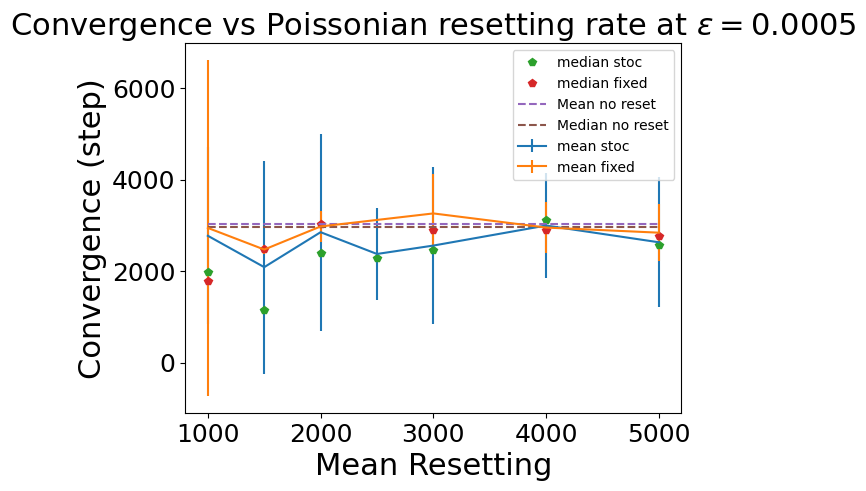

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

zoom_sup_stoc=15
zoom_inf_stoc=0

zoom_sup_fixed=8
zoom_inf_fixed=0

plt.errorbar(mean_values_array_stoc[zoom_inf_stoc:zoom_sup_stoc],mean_convergences_stoc[zoom_inf_stoc:zoom_sup_stoc],yerr=std_convergences_stoc[zoom_inf_stoc:zoom_sup_stoc],label='mean stoc')
plt.errorbar(mean_values_array_fixed[zoom_inf_fixed:zoom_sup_fixed],mean_convergences_fixed[zoom_inf_fixed:zoom_sup_fixed],yerr=std_convergences_fixed[zoom_inf_fixed:zoom_sup_fixed],label='mean fixed')
plt.plot(mean_values_array_stoc[zoom_inf_stoc:zoom_sup_stoc],median_convergence_stoc[zoom_inf_stoc:zoom_sup_stoc],'p',label='median stoc')
plt.plot(mean_values_array_fixed[zoom_inf_fixed:zoom_sup_fixed],median_convergence_fixed[zoom_inf_fixed:zoom_sup_fixed],'p',label='median fixed')
plt.plot(mean_values_array_stoc[zoom_inf_stoc:zoom_sup_stoc],mean_convergence_no_reset_array[zoom_inf_stoc:zoom_sup_stoc],'--',label='Mean no reset')
plt.plot(mean_values_array_stoc[zoom_inf_stoc:zoom_sup_stoc],median_convergence_no_reset_array[zoom_inf_stoc:zoom_sup_stoc],'--',label='Median no reset')
plt.xlabel("Mean Resetting",fontsize='22')
plt.ylabel("Convergence (step)",fontsize='22')
plt.title(f"Convergence vs Poissonian resetting rate at $\epsilon=${threshold}",fontsize='22')
plt.tick_params(labelsize=18)
plt.legend(fontsize=10)
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Fixed reseating
[2490, 2350, 2530, 2400, 2580, 2510, 2330, 2560, 2570, 2440, 2340, 2460, 2360, 2570, 2690, 2470, 2490, 2380, 2570, 2350]
Stochastic reseating
[1867, 870, 1120, 939, 8722, 1115, 2310, 1165, 1494, 1092, 677, 8845, 3522, 793, 1283, 1779, 772, 849, 1906, 615]


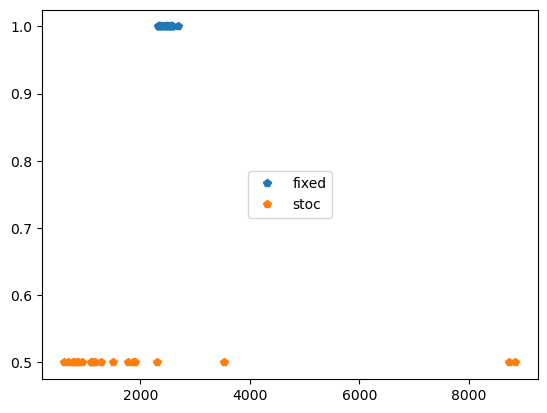

In [11]:
import pandas as pd
import numpy as np
import re
import os

mean=1500.0
A='fixed'

# Define the directory where the files are stored
data_folder = "tests/adam_meanLoss_"+A+"_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)

# List all the filenames in the directory
file_names = os.listdir(data_folder)

# Initialize an empty list to store the mean values
sample_fixed = []

# Regular expression pattern to match the mean value in the filename
pattern = r"training_loss_mean"+str(mean)+r"_sample(\d+|\d+).txt"

# Iterate over the filenames and extract the mean values
for file_name in file_names:
    match = re.search(pattern, file_name)
    if match:
        # Convert the extracted mean value to a float and add it to the list
        sample = int(match.group(1))
        sample_fixed.append(sample)

# Convert the list of mean values to a NumPy array
sample_array_fixed = np.array(sample_fixed)
sorted_index =sample_array_fixed.argsort()
sample_array_fixed=np.take_along_axis(sample_array_fixed, sorted_index,axis=-1)
print(sample_array_fixed)

step_tot_fixed=[]
step_tot_stoc=[]
for s in sample_array_fixed:
    df_fixed = pd.read_csv("tests/adam_meanLoss_fixed_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_mean"+str(mean)+"_sample"+str(s)+".txt")
    df_stoc = pd.read_csv("tests/adam_meanLoss_stoc_lr"+str(learning_rate)+"_std"+str(std)+"_bas"+str(basis_added_step)+"_treshold"+str(threshold)+"/training_loss_mean"+str(mean)+"_sample"+str(s)+".txt")

    #Select the last 'step' value
    step_tot_fixed.append(df_fixed['step'].iloc[-1])
    step_tot_stoc.append(df_stoc['step'].iloc[-1])

population=np.ones(len(step_tot_fixed))

print('Fixed reseating')
print(step_tot_fixed)  
print('Stochastic reseating')
print(step_tot_stoc)

outfile_fixed = open(("fixed_disp"),'w')
for r in step_tot_fixed :
    outfile_fixed.write('%f %f \n' %(r,1))

outfile_stoc = open(("stoc_disp"),'w')
for r in step_tot_stoc :
    outfile_stoc.write('%f %f \n' %(r,-1))

plt.plot(step_tot_fixed,population,'p',label='fixed')
plt.plot(step_tot_stoc,0.5*population,'p',label='stoc')
plt.legend(loc='center')
plt.show()


